In [2]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

Define time-dependent Rabi frequency, $\Omega(t)$, and detuning parameter, $\Delta(t)$

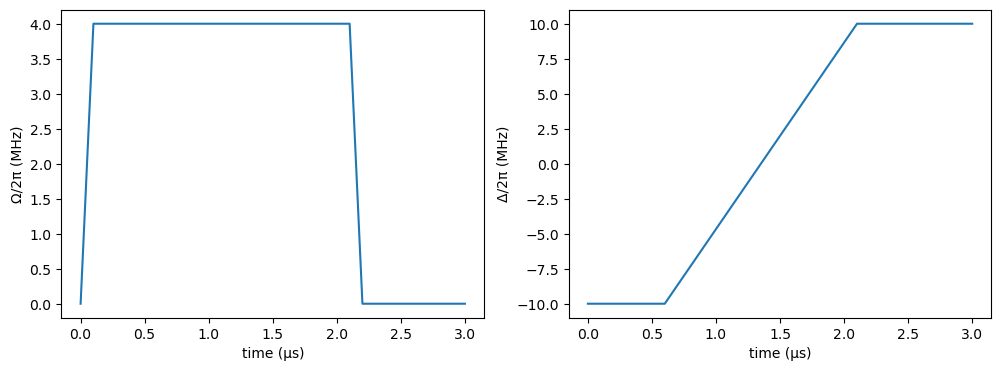

In [3]:
t_tot = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, t_tot], values = [0.0, Ω_max, Ω_max, 0, 0]);
U = 2π * 10; 
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, t_tot], values = [-U, -U, U, U]);

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Create 1D chain with 9 atom sites

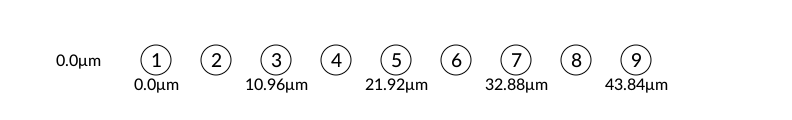

In [4]:
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.48)

Define time-dependent Rydberg Hamiltonian

In [5]:
h = rydberg_h(atoms; Δ, Ω)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


Set all atoms to ground state in initial state and set up time-evolution problem

In [17]:
reg = zero_state(9);
prob = SchrodingerProblem(reg, t_tot, h);
integrator = init(prob, Vern8());

Calculate the site number densities, $\langle n_i(t)\rangle$, as the initial state adiabatically time-evolves

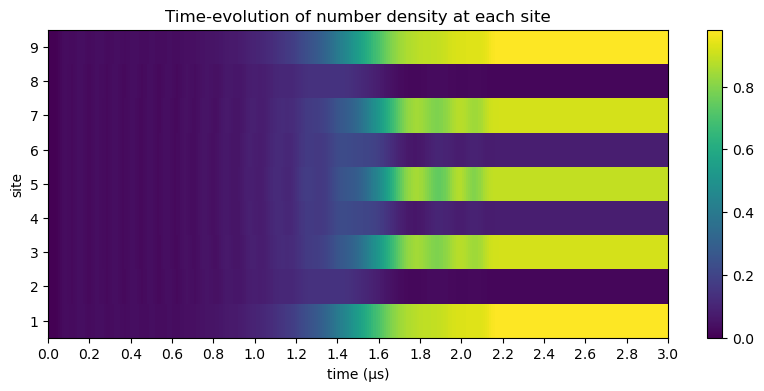

In [18]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-2:t_tot)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, t_tot, 0.5, nsites + 0.5])
ax.set_title("Time-evolution of number density at each site")
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:t_tot)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

In [19]:
measure(reg)[]

101010101 ₍₂₎

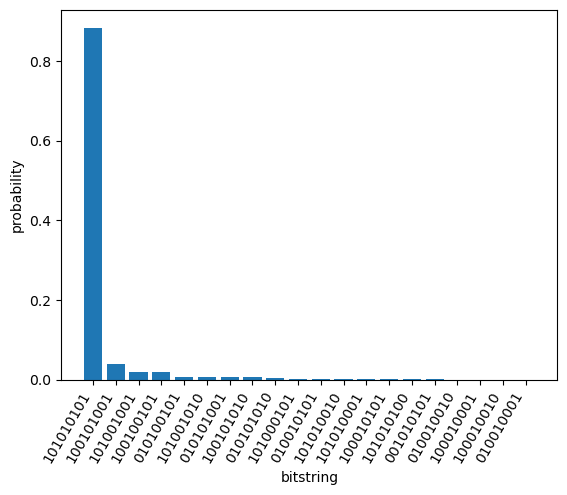

In [20]:
bitstring_hist(reg; nlargest = 20)

Energy of ground and first excited states

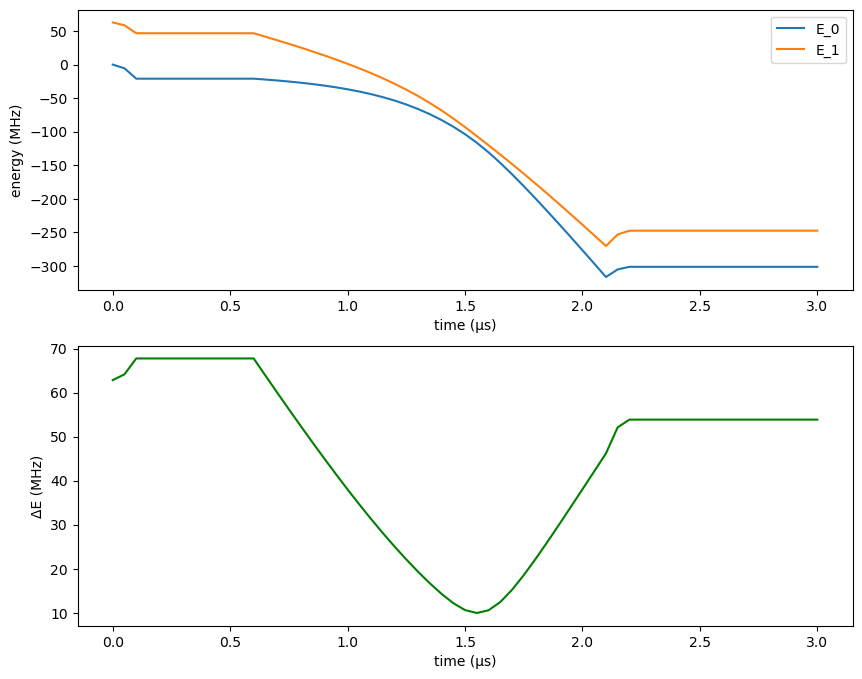

In [9]:
E0 = []; E1 = [];
tseq = collect(0.0:0.05:t_tot)
for t in tseq
    ht = h |> attime(t)
    h_m = mat(ht)
    vals, vecs, info = KrylovKit.eigsolve(h_m, 5, :SR)
    push!(E0, vals[1]);push!(E1, vals[2]);
end

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10, 8))
ax1.plot(tseq, E0, label = "E_0")
ax1.plot(tseq, E1, label = "E_1")
ax1.set_xlabel("time (μs)")
ax1.set_ylabel("energy (MHz)")
ax1.legend()
ax2.plot(tseq, E1 - E0, 'g')
ax2.set_xlabel("time (μs)")
ax2.set_ylabel("ΔE (MHz)")
fig

In [11]:
minimum(E1 - E0)

9.95423632964821

Expectation value, $\langle\sigma^x_i\rangle$, at each site

In [23]:
measure(reg)[]

101010101 ₍₂₎

In [22]:
println("Expectation value of X at site")
for i in 1:9
    println(i, ": ", expect(put(9,i=>X), reg))
end

Expectation value of X at site
1: -0.0009154741016707858 + 0.0im
2: -0.002741274442991784 + 0.0im
3: 0.01565263209333362 + 0.0im
4: -0.002034021969768495 - 1.0842021724855044e-19im
5: 0.02624159404006243 + 0.0im
6: -0.0020340219697753278 - 2.168404344971009e-19im
7: 0.0156526320931435 + 6.938893903907228e-18im
8: -0.0027412744429678765 + 4.336808689942018e-19im
9: -0.0009154741018149708 + 0.0im
